# Configuração

## Importação

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

/home/dti-dev/.local/share/virtualenvs/spotify-music-recomendation-_5l54QgE/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definição do Dataframe

In [2]:
df = pd.read_csv("../datasets/data_clean.csv")

## Estilização

In [3]:
spotify_colors = {
    "primary": "#38E07B",
    "background_seg": "#122017",
    "background_primary": "#173422",
    "light": "#FFFFFF",
    "text": "#B3B3B3",
    "charts": "#1DB954",
    "select": "#10B981",
}

In [4]:
css_styles = f"""
    .gradio-container {{
        background: linear-gradient(135deg, {spotify_colors["background_primary"]} 0%, {spotify_colors["background_seg"]} 100%) !important;
    }}
    
    .block {{
        background-color: {spotify_colors["background_seg"]} !important;
        border-color: {spotify_colors["primary"]} !important;
    }}
    
    .container > div {{
        background-color: {spotify_colors["charts"]} !important;
        
        ul {{
            li {{
                background-color: {spotify_colors["select"]} !important;
            }}
            
            li:hover, li:active {{
                background-color: {spotify_colors["charts"]} !important;
            }}
        }}
    }}
    """

# Análise Exploratória

## Correlação

### Gráfico

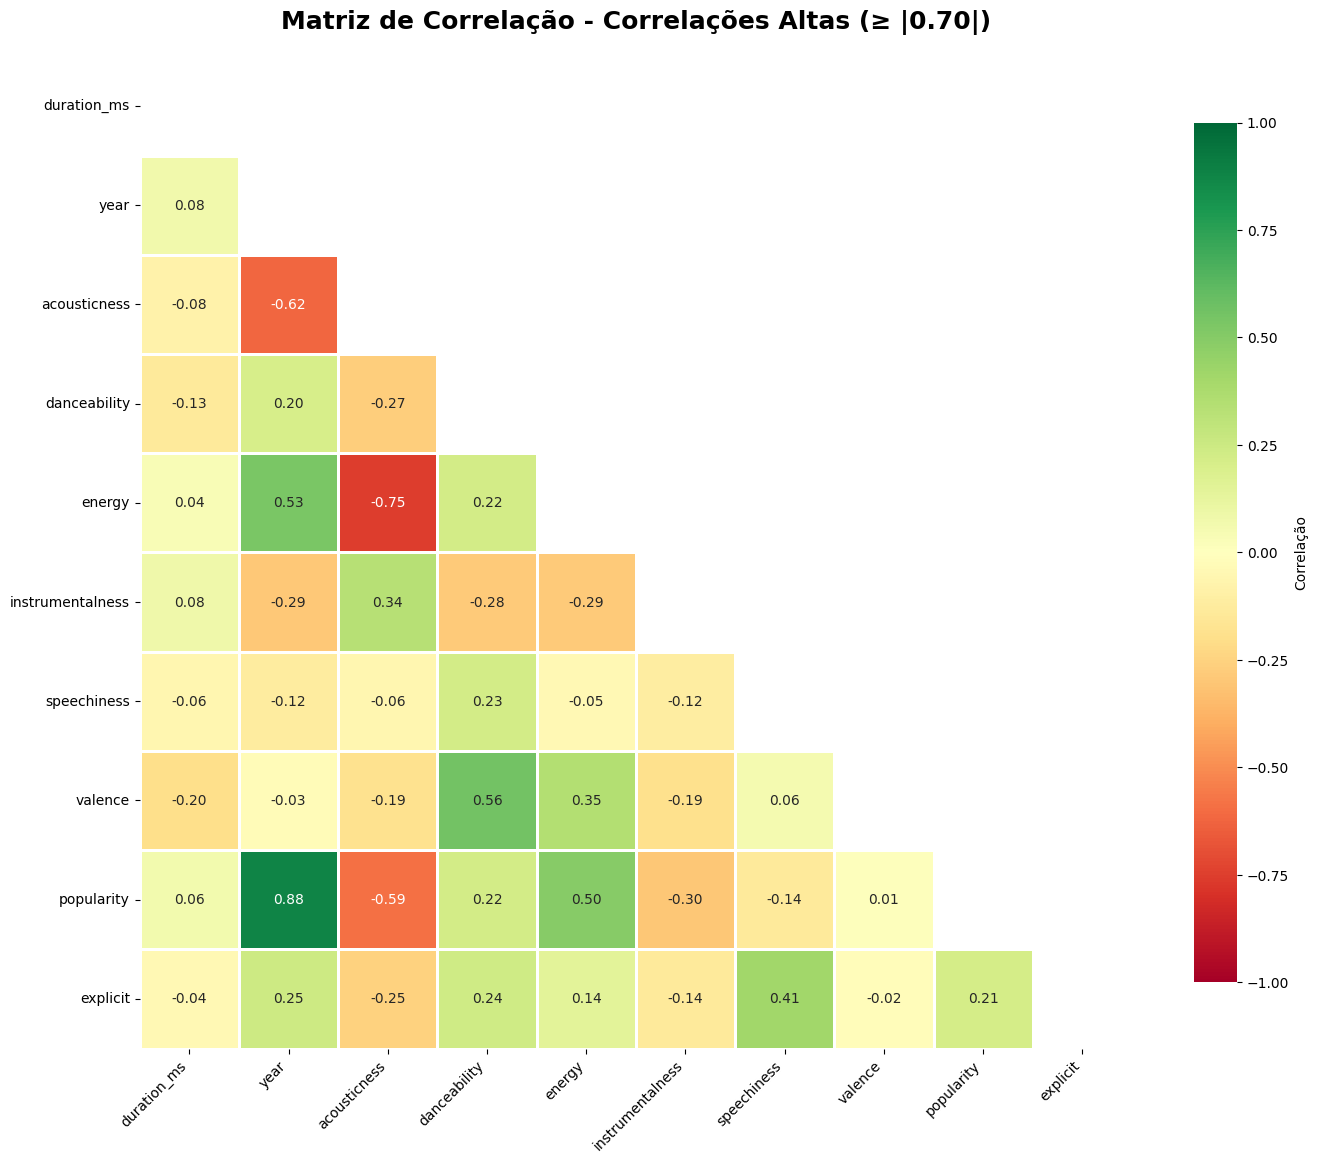

In [5]:
correlation_matrix = df.corr(numeric_only=True)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)

filtered_matrix = correlation_matrix.copy()

plt.figure(figsize=(14, 12))
sns.heatmap(
    filtered_matrix,
    annot=True,
    cmap="RdYlGn",
    center=0,
    fmt=".2f",
    square=True,
    linewidths=1,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "label": "Correlação"},
    annot_kws={"size": 10},
    vmin=-1,
    vmax=1,
    mask=mask,
)
plt.title(
    "Matriz de Correlação - Correlações Altas (≥ |0.70|)",
    fontsize=18,
    fontweight="bold",
    pad=20,
)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Resumo

In [6]:
corr_summary = pd.DataFrame(
    {
        "Métrica": [
            "Total de Features",
            "Correlações Positivas Altas (>0.7)",
            "Correlações Negativas Altas (<-0.7)",
            "Correlações Moderadas (0.5-0.7)",
            "Correlações Fracas (<0.3)",
            "Valor Máximo de Correlação",
            "Valor Mínimo de Correlação",
        ],
        "Valor": [
            correlation_matrix.shape[0],
            len(
                correlation_matrix[
                    (correlation_matrix > 0.7) & (correlation_matrix < 1)
                ]
                .stack()
                .dropna()
            ),
            len(correlation_matrix[(correlation_matrix < -0.7)].stack().dropna()),
            len(
                correlation_matrix[
                    ((correlation_matrix >= 0.5) & (correlation_matrix < 0.7))
                    | ((correlation_matrix <= -0.5) & (correlation_matrix > -0.7))
                ]
                .stack()
                .dropna()
            ),
            len(
                correlation_matrix[
                    (correlation_matrix.abs() < 0.3) & (correlation_matrix != 0)
                ]
                .stack()
                .dropna()
            ),
            correlation_matrix.values[correlation_matrix.values < 1].max(),
            correlation_matrix.values.min(),
        ],
    }
)

display(corr_summary)

,Métrica,Valor
0,Total de Features,10.000000
1,Correlações Positivas Altas (>0.7),2.000000
2,Correlações Negativas Altas (<-0.7),2.000000
3,Correlações Moderadas (0.5-0.7),8.000000
4,Correlações Fracas (<0.3),70.000000
5,Valor Máximo de Correlação,0.880725
6,Valor Mínimo de Correlação,-0.750282


## Análise Descritiva das Features

### Setup

In [7]:
df.columns

Index(['id', 'name', 'artists', 'duration_ms', 'year', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence',
       'popularity', 'explicit'],
      dtype='object')

In [8]:
features = [
    "year",
    "popularity",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "speechiness",
    "valence",
    "explicit",
]

In [9]:
print(f"\n📋 Features a analisar ({len(features)}):")
for i, feat in enumerate(features, 1):
    print(f"   {i}. {feat}")


📋 Features a analisar (9):
   1. year
   2. popularity
   3. acousticness
   4. danceability
   5. energy
   6. instrumentalness
   7. speechiness
   8. valence
   9. explicit


In [10]:
def calcular_stats(feature_nome):
    return {
        "min": df[feature_nome].min(),
        "max": df[feature_nome].max(),
        "mean": df[feature_nome].mean(),
        "median": df[feature_nome].median(),
        "std": df[feature_nome].std(),
    }


def criar_grafico_stats(feature_selecionada):
    if feature_selecionada is None:
        feature_selecionada = features[0]

    stats = calcular_stats(feature_selecionada)

    stats_data = pd.DataFrame(
        {
            "Estatística": ["Mínimo", "Média", "Mediana", "Máximo"],
            "Valor": [stats["min"], stats["mean"], stats["median"], stats["max"]],
        }
    )

    return {
        "value": stats_data,
        "title": f"Min, Média, Mediana, Máx - {feature_selecionada.capitalize()}",
    }


def criar_grafico_distribuicao(feature_selecionada):
    if feature_selecionada is None:
        feature_selecionada = features[0]

    counts, bins = np.histogram(df[feature_selecionada], bins=40)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    distribuicao_data = pd.DataFrame({"Valor": bin_centers, "Frequência": counts})

    return {
        "value": distribuicao_data,
        "title": f"Histograma de Distribuição - {feature_selecionada.capitalize()}",
    }

### Gráficos

In [11]:
with gr.Blocks(
    theme=gr.themes.Soft(primary_hue="emerald", secondary_hue="slate"), css=css_styles
) as demo:
    gr.Markdown("## Análise Descritiva de Features")

    with gr.Row():
        feature_select = gr.Dropdown(
            choices=features,
            value=features[0],
            label="Selecione uma Feature",
            interactive=True,
            scale=1,
        )

    with gr.Row():
        with gr.Column(scale=1):
            stats_plot = gr.BarPlot(
                x="Estatística",
                y="Valor",
                title="Min, Média, Mediana, Máx - Year",
                height=400,
                tooltip=["Estatística", "Valor"],
                show_actions_button=True,
                x_title="Estatísticas",
                y_title="Valores",
            )
        with gr.Column(scale=1):
            dist_plot = gr.BarPlot(
                x="Valor",
                y="Frequência",
                title="Histograma de Distribuição - Year",
                height=400,
                tooltip=["Valor", "Frequência"],
                show_actions_button=True,
                x_title="Faixas de Valor",
                y_title="Frequência",
                interactive=True,
            )

            def select_region(selection: gr.SelectData):
                min_w, max_w = selection.index
                return gr.LinePlot(x_lim=(min_w, max_w))

            dist_plot.select(select_region, None, dist_plot)
            dist_plot.double_click(lambda: gr.BarPlot(x_lim=None), None, dist_plot)

    def update_stats(feature):
        result = criar_grafico_stats(feature)
        return gr.BarPlot(value=result["value"], title=result["title"])

    def update_dist(feature):
        result = criar_grafico_distribuicao(feature)
        return gr.BarPlot(value=result["value"], title=result["title"])

    feature_select.change(fn=update_stats, inputs=feature_select, outputs=stats_plot)
    feature_select.change(fn=update_dist, inputs=feature_select, outputs=dist_plot)

    demo.load(fn=update_stats, inputs=feature_select, outputs=stats_plot)
    demo.load(fn=update_dist, inputs=feature_select, outputs=dist_plot)

demo.launch(share=False)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


### Resumo

In [12]:
descriptive_summary = pd.DataFrame(
    {
        "Feature": features,
        "Min": [df[feat].min() for feat in features],
        "Max": [df[feat].max() for feat in features],
        "Média": [df[feat].mean() for feat in features],
        "Mediana": [df[feat].median() for feat in features],
        "Std Dev": [df[feat].std() for feat in features],
        "Skewness": [df[feat].skew() for feat in features],
        "Contagem": [df[feat].count() for feat in features],
    }
)

display(descriptive_summary.round(4))

,Feature,Min,Max,Média,Mediana,Std Dev,Skewness,Contagem
0,year,1921.0,2020.000,1977.2232,1978.0000,25.5933,-0.1327,169907
1,popularity,0.0,100.000,31.5567,33.0000,21.5827,-0.0215,169907
2,acousticness,0.0,0.996,0.4932,0.4920,0.3766,0.0087,169907
3,danceability,0.0,0.988,0.5381,0.5480,0.1753,-0.2129,169907
4,energy,0.0,1.000,0.4886,0.4810,0.2674,0.0774,169907
5,instrumentalness,0.0,1.000,0.1619,0.0002,0.3093,1.6815,169907
6,speechiness,0.0,0.969,0.0941,0.0450,0.1499,4.2358,169907
7,valence,0.0,1.000,0.5321,0.5440,0.2624,-0.1240,169907
8,explicit,0.0,1.000,0.0849,0.0000,0.2787,2.9793,169907


## Músicas por década

### Setup

In [13]:
df["decade"] = (df["year"] // 10 * 10).astype(int)

decades_data = df.groupby("decade")[features].mean()
decades_data["count"] = df.groupby("decade").size()
decades_data = decades_data.reset_index()

decades_data["decade_str"] = decades_data["decade"].astype(str) + "s"

count_data_initial = pd.DataFrame(
    {"decade_str": decades_data["decade_str"], "count": decades_data["count"]}
)

### Gráficos

In [14]:
with gr.Blocks(
    theme=gr.themes.Soft(primary_hue="emerald", secondary_hue="slate"), css=css_styles
) as demo_decades:
    gr.Markdown("## Análise de Features por Década")

    with gr.Row():
        feature_decade_select = gr.Dropdown(
            choices=features[1:],
            value="energy",
            label="Selecione uma Feature",
            interactive=True,
            scale=1,
        )

    with gr.Row():
        with gr.Column(scale=1):
            feature_plot = gr.BarPlot(
                value=pd.DataFrame(
                    {
                        "decade_str": decades_data["decade_str"],
                        "valor": decades_data["energy"],
                    }
                ),
                x="decade_str",
                y="valor",
                title="Média de Energy por Década",
                height=400,
                tooltip=["decade_str", "valor"],
                show_actions_button=True,
                x_title="Década",
                y_title="Valor Médio",
                x_label_angle=45,
            )

        with gr.Column(scale=1):
            count_plot = gr.BarPlot(
                value=pd.DataFrame(
                    {
                        "decade_str": decades_data["decade_str"],
                        "count": decades_data["count"],
                    }
                ),
                x="decade_str",
                y="count",
                title="Quantidade de Músicas por Década",
                height=400,
                tooltip=["decade_str", "count"],
                show_actions_button=True,
                x_title="Década",
                y_title="Quantidade de Músicas",
                x_label_angle=45,
            )

    def atualizar_feature_decada(feature_selecionada):
        feature_display = {
            "energy": "Energy",
            "danceability": "Danceability",
            "valence": "Valence",
            "popularity": "Popularity",
            "acousticness": "Acousticness",
        }

        data = pd.DataFrame(
            {
                "decade_str": decades_data["decade_str"],
                "valor": decades_data[feature_selecionada],
            }
        )

        feature_name = feature_display.get(feature_selecionada, feature_selecionada)
        title = f"Média de {feature_name} por Década"

        return gr.BarPlot(value=data, title=title)

    feature_decade_select.change(
        fn=atualizar_feature_decada, inputs=feature_decade_select, outputs=feature_plot
    )

demo_decades.launch(share=False)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


### Resumo

In [15]:
decade_summary = pd.DataFrame(
    {
        "Década": decades_data["decade_str"],
        "Quantidade": decades_data["count"].astype(int),
        "Acousticness": decades_data["acousticness"].round(3),
        "Danceability": decades_data["danceability"].round(3),
        "Energy": decades_data["energy"].round(3),
        "Instrumentalness": decades_data["instrumentalness"].round(3),
        "Speechiness": decades_data["speechiness"].round(3),
        "Valence": decades_data["valence"].round(3),
        "Popularity": decades_data["popularity"].round(2),
    }
)

display(decade_summary)

,Década,Quantidade,Acousticness,Danceability,Energy,Instrumentalness,Speechiness,Valence,Popularity
0,1920s,4446,0.831,0.577,0.241,0.416,0.232,0.567,1.33
1,1930s,8889,0.875,0.536,0.288,0.288,0.168,0.576,2.51
2,1940s,14968,0.871,0.472,0.253,0.364,0.147,0.485,1.65
3,1950s,19950,0.840,0.477,0.287,0.243,0.097,0.477,9.95
4,1960s,20000,0.621,0.497,0.416,0.155,0.059,0.557,25.63
5,1970s,19998,0.392,0.527,0.539,0.114,0.061,0.588,35.05
6,1980s,20000,0.286,0.550,0.602,0.118,0.063,0.570,37.00
7,1990s,20000,0.292,0.572,0.595,0.102,0.083,0.550,43.63
8,2000s,20000,0.259,0.576,0.659,0.078,0.088,0.533,49.41
9,2010s,19900,0.256,0.599,0.633,0.071,0.101,0.462,59.56


## Análise de Thresholds para binarização

In [ ]:
def analyze_threshold_for_binarization(column, threshold_range=(20, 71), verbose=True):
    if verbose:
        print("=" * 90)
        print(f"📊 ANÁLISE COMPLETA PARA DEFINIÇÃO DE THRESHOLD - {column.upper()}")
        print("=" * 90)

        print(f"\n🎯 ESTATÍSTICAS DESCRITIVAS - {column.upper()}")
        print("-" * 90)
        col_stats = df[column].describe()
        print(col_stats)

        print(f"\nModa (valor mais frequente): {df[column].mode().values}")
        print(f"Assimetria (Skewness): {df[column].skew():.4f}")
        print(f"Curtose (Kurtosis): {df[column].kurtosis():.4f}")

    if verbose:
        print("\n" + "=" * 90)
        print("📈 CÁLCULO DE MÉTRICAS PARA TODOS OS THRESHOLDS")
        print("=" * 90)

    thresholds_to_test = range(threshold_range[0], threshold_range[1])
    threshold_metrics = []

    for t in thresholds_to_test:
        neg_class = len(df[df[column] <= t])
        pos_class = len(df[df[column] > t])

        pct_neg = (neg_class / len(df)) * 100
        pct_pos = (pos_class / len(df)) * 100

        imbalance_ratio = (
            max(neg_class, pos_class) / min(neg_class, pos_class)
            if min(neg_class, pos_class) > 0
            else float("inf")
        )

        pct_diff = abs(pct_neg - pct_pos)

        balance_score = pct_diff

        threshold_metrics.append(
            {
                "threshold": t,
                "class_0": neg_class,
                "class_1": pos_class,
                "pct_0": pct_neg,
                "pct_1": pct_pos,
                "imbalance_ratio": imbalance_ratio,
                "pct_diff": pct_diff,
                "balance_score": balance_score,
            }
        )

    metrics_df = pd.DataFrame(threshold_metrics)
    if verbose:
        print(
            f"✅ Dataframe de métricas criado com {len(metrics_df)} thresholds testados"
        )

    if verbose:
        print("\n" + "-" * 90)
        print("📊 CRITÉRIO 1: BALANCEAMENTO ÓTIMO (50%-50%)")
        print("-" * 90)

    best_balanced_idx = metrics_df["balance_score"].idxmin()
    best_balanced = metrics_df.loc[best_balanced_idx]

    if verbose:
        print(
            f"\n🏆 Threshold com melhor balanceamento: {int(best_balanced['threshold'])}"
        )
        print(
            f"   → Classe 0: {int(best_balanced['class_0'])} ({best_balanced['pct_0']:.1f}%)"
        )
        print(
            f"   → Classe 1: {int(best_balanced['class_1'])} ({best_balanced['pct_1']:.1f}%)"
        )
        print(f"   → Razão Desbalance: {best_balanced['imbalance_ratio']:.2f}x")

    if verbose:
        print("\n" + "-" * 90)
        print("📊 CRITÉRIO 2: DISTRIBUIÇÃO NATURAL (Baseado em Quartis)")
        print("-" * 90)

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    if verbose:
        print("\n📌 Quartis da Distribuição:")
        print(f"   → Q1 (25%): {q1:.1f}")
        print(f"   → Q3 (75%): {q3:.1f}")

    # Encontrar threshold mais próximo do Q3
    q3_idx = (metrics_df["threshold"] - q3).abs().idxmin()
    q3_threshold = metrics_df.loc[q3_idx]

    if verbose:
        print(f"\n🏆 Threshold próximo ao Q3: {int(q3_threshold['threshold'])}")
        print(
            f"   → Classe 0: {int(q3_threshold['class_0'])} ({q3_threshold['pct_0']:.1f}%)"
        )
        print(
            f"   → Classe 1: {int(q3_threshold['class_1'])} ({q3_threshold['pct_1']:.1f}%)"
        )
        print(f"   → Razão Desbalance: {q3_threshold['imbalance_ratio']:.2f}x")

    if verbose:
        print("\n" + "-" * 90)
        print("📊 CRITÉRIO 3: RAZÃO DESBALANCE ≤ 2.0x")
        print("-" * 90)

    acceptable = metrics_df[metrics_df["imbalance_ratio"] <= 2.0]

    if len(acceptable) > 0:
        best_acceptable_idx = acceptable["balance_score"].idxmin()
        best_acceptable = metrics_df.loc[best_acceptable_idx]

        if verbose:
            print(
                f"\n✅ Thresholds aceitáveis (imbalance ≤ 2.0x): {len(acceptable)} opções"
            )
            print(
                f"\n🏆 Melhor entre os aceitáveis: {int(best_acceptable['threshold'])}"
            )
            print(
                f"   → Classe 0: {int(best_acceptable['class_0'])} ({best_acceptable['pct_0']:.1f}%)"
            )
            print(
                f"   → Classe 1: {int(best_acceptable['class_1'])} ({best_acceptable['pct_1']:.1f}%)"
            )
            print(f"   → Razão Desbalance: {best_acceptable['imbalance_ratio']:.2f}x")

        acceptable_range_min = int(acceptable["threshold"].min())
        acceptable_range_max = int(acceptable["threshold"].max())
    else:
        if verbose:
            print("\n⚠️  Nenhum threshold com imbalance ≤ 2.0x encontrado")

        acceptable = metrics_df[metrics_df["imbalance_ratio"] <= 2.5]

        if len(acceptable) > 0:
            if verbose:
                print("   Tentando com limiar relaxado (≤ 2.5x)...")
            best_acceptable_idx = acceptable["balance_score"].idxmin()
            best_acceptable = metrics_df.loc[best_acceptable_idx]

            if verbose:
                print(
                    f"\n✅ Thresholds aceitáveis (imbalance ≤ 2.5x): {len(acceptable)} opções"
                )
                print(
                    f"\n🏆 Melhor entre os aceitáveis: {int(best_acceptable['threshold'])}"
                )
                print(
                    f"   → Classe 0: {int(best_acceptable['class_0'])} ({best_acceptable['pct_0']:.1f}%)"
                )
                print(
                    f"   → Classe 1: {int(best_acceptable['class_1'])} ({best_acceptable['pct_1']:.1f}%)"
                )
                print(
                    f"   → Razão Desbalance: {best_acceptable['imbalance_ratio']:.2f}x"
                )

            acceptable_range_min = int(acceptable["threshold"].min())
            acceptable_range_max = int(acceptable["threshold"].max())
        else:
            if verbose:
                print("   Nenhum threshold com imbalance ≤ 2.5x encontrado")
                print("   Usando o melhor balanceamento disponível (critério 1)")

            best_acceptable = metrics_df.loc[metrics_df["balance_score"].idxmin()]

            acceptable_range_min = int(metrics_df["threshold"].min())
            acceptable_range_max = int(metrics_df["threshold"].max())

    if verbose:
        print("\n" + "=" * 90)
        print("📊 COMPARAÇÃO DOS TRÊS CRITÉRIOS")
        print("=" * 90)

    comparison_df = pd.DataFrame(
        {
            "Critério": [
                "Critério 1: Melhor Balanceamento",
                "Critério 2: Distribuição Natural (Q3)",
                "Critério 3: Razão Desbalance ≤ 2.0x",
            ],
            "Threshold": [
                int(best_balanced["threshold"]),
                int(q3_threshold["threshold"]),
                int(best_acceptable["threshold"]),
            ],
            "Classe 0 (%)": [
                f"{best_balanced['pct_0']:.1f}%",
                f"{q3_threshold['pct_0']:.1f}%",
                f"{best_acceptable['pct_0']:.1f}%",
            ],
            "Classe 1 (%)": [
                f"{best_balanced['pct_1']:.1f}%",
                f"{q3_threshold['pct_1']:.1f}%",
                f"{best_acceptable['pct_1']:.1f}%",
            ],
            "Razão Desbalance": [
                f"{best_balanced['imbalance_ratio']:.2f}x",
                f"{q3_threshold['imbalance_ratio']:.2f}x",
                f"{best_acceptable['imbalance_ratio']:.2f}x",
            ],
        }
    )

    if verbose:
        print("\n" + comparison_df.to_string(index=False))

    if verbose:
        print("\n" + "=" * 90)
        print("✨ RECOMENDAÇÃO FINAL")
        print("=" * 90)

    recommended_threshold = int(best_acceptable["threshold"])

    if verbose:
        print(f"\n🎯 THRESHOLD RECOMENDADO: {recommended_threshold}")
        print("\n📊 Justificativa:")
        print(
            f"   • Balanceamento: {best_acceptable['pct_0']:.1f}% vs {best_acceptable['pct_1']:.1f}%"
        )
        print(
            f"   • Razão de desbalance: {best_acceptable['imbalance_ratio']:.2f}x (aceitável para ML)"
        )
        print(f"   • Diferença entre classes: {best_acceptable['pct_diff']:.1f}%")

        print("\n📈 Intervalo de confiança:")
        print(
            f"   • Zona recomendada: {recommended_threshold - 5} a {recommended_threshold + 5}"
        )
        print(
            f"   • Intervalo expandido: {acceptable_range_min} a {acceptable_range_max}"
        )

        print("\n" + "=" * 90)

    return {
        "recommended_threshold": recommended_threshold,
        "metrics_df": metrics_df,
        "best_balanced": best_balanced,
        "q3_threshold": q3_threshold,
        "best_acceptable": best_acceptable,
        "comparison_df": comparison_df,
        "acceptable_range": (acceptable_range_min, acceptable_range_max),
    }


resultado_popularity = analyze_threshold_for_binarization(
    column="popularity", threshold_range=(20, 71), verbose=True
)

resultado_speechiness = analyze_threshold_for_binarization(
    column="speechiness", threshold_range=(0, 20), verbose=True
)

resultado_instrumentalness = analyze_threshold_for_binarization(
    column="instrumentalness", threshold_range=(0, 20), verbose=True
)

POPULARITY_THRESHOLD = resultado_popularity["recommended_threshold"]
print(f"\n✅ Threshold recomendado para 'popularity': {POPULARITY_THRESHOLD}")

SPEECHINESS_THRESHOLD = resultado_speechiness["recommended_threshold"]
print(f"\n✅ Threshold recomendado para 'speechiness': {SPEECHINESS_THRESHOLD}")

INSTRUMENTALNESS_THRESHOLD = resultado_instrumentalness["recommended_threshold"]
print(
    f"\n✅ Threshold recomendado para 'instrumentalness': {INSTRUMENTALNESS_THRESHOLD}"
)

📊 ANÁLISE COMPLETA PARA DEFINIÇÃO DE THRESHOLD - POPULARITY

🎯 ESTATÍSTICAS DESCRITIVAS - POPULARITY
------------------------------------------------------------------------------------------


count    169907.000000
mean         31.556681
std          21.582730
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

Moda (valor mais frequente): [0]
Assimetria (Skewness): -0.0215
Curtose (Kurtosis): -1.0150

📈 CÁLCULO DE MÉTRICAS PARA TODOS OS THRESHOLDS
✅ Dataframe de métricas criado com 51 thresholds testados

------------------------------------------------------------------------------------------
📊 CRITÉRIO 1: BALANCEAMENTO ÓTIMO (50%-50%)
------------------------------------------------------------------------------------------

🏆 Threshold com melhor balanceamento: 33
   → Classe 0: 84964 (50.0%)
   → Classe 1: 84943 (50.0%)
   → Razão Desbalance: 1.00x

------------------------------------------------------------------------------------------
📊 CRITÉRIO 2: DISTRIBUIÇÃO NATURAL (Baseado em Quartis)
--------------------------------------------------------------------------------

# Insights

#### **1. Year (Ano)**

* **Min**: 1921 (aproximadamente) | **Média**: ~1977 | **Max**: 2020
* **Amplitude**: 99 anos (1921 a 2020)
* **Distribuição**: Próxima do uniforme/retangular na fase madura.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): A frequência de músicas por ano é baixa nas décadas iniciais (1920s-1940s), mas atinge um **volume alto e estável** (cerca de 6.000 músicas por faixa) a partir de 1950.
* Forma: Exponencial inicial, estabilizando para um formato retangular.
* Observações: O volume de dados é bem representado nas décadas mais recentes (1950-2010s).

**⚠️ Problemas Identificados:**
* Viés temporal: Distribuição de frequência significativamente menor (enviesada) nas primeiras décadas (1920s-1940s).

**📅 Tendência Temporal:**
* Resumo Temporal: A variável *Year* (Ano) é a dimensão temporal primária, indicando a distribuição de volume de dados, que é alta e estável a partir de 1950.

**Status**: 🟢 **MANTER**
* **Ação recomendada**: Manter, pois é a variável de tempo fundamental.

---

#### **2. Popularity (Popularidade)**

* **Min**: 0 | **Média**: ~32 | **Max**: 100
* **Amplitude**: 100
* **Distribuição**: Altamente assimétrica (positivamente/à direita), com forte concentração em valores baixos.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): O pico de frequência principal está concentrado na primeira faixa (0-5), com mais de 30.000 ocorrências. Isso indica que a maioria das músicas no dataset tem baixa popularidade.
* Densidade: A distribuição se espalha mais uniformemente apenas entre 30 e 60.

**📅 Tendência Temporal:**
* Interpretação: Tendência de **aumento progressivo e consistente** da Popularidade Média ao longo das décadas. O valor médio era muito baixo nos anos 1920s a 1940s (~2), mas cresceu continuamente, atingindo o valor mais alto nos anos 2020s (acima de 60).

**Status**: 🟢 **MANTER**
* **Ação recomendada**: Manter devido à forte e clara tendência temporal observada.

---

#### **3. Speechiness (Conteúdo de Fala)**

* **Min**: 0.0 | **Média**: ~0.1 | **Max**: 1.0
* **Distribuição**: Altamente assimétrica (positivamente/à direita), com concentração extrema próxima de zero.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): Concentração maciça (acima de 90.000 ocorrências) na primeira faixa (0.00-0.05), indicando que a **grande maioria das músicas possui baixíssimo teor de fala**.
* Forma: Exponencial/Power Law, concentrada no limite inferior.

**⚠️ Problemas Identificados:**
* Concentração extrema (quase Delta-like), resultando em baixa variância na maioria dos dados, o que pode impactar o aprendizado do modelo.

**📅 Tendência Temporal:**
* Interpretação: A média de *Speechiness* era alta nos anos 1920s (~0.23), caiu drasticamente até os anos 1960s (~0.06), e tem mostrado um leve aumento recente, atingindo ~0.14 na década de 2020s.

**Status**: 🟡 **TRANSFORMAR**
* **Ação recomendada**: Log-transformação ou binarização, para mitigar o pico em zero.

---

#### **4. Valence (Valência / Positividade)**

* **Min**: 0.0 | **Média**: ~0.53 | **Max**: 1.0
* **Amplitude**: 1.0
* **Distribuição**: Próxima da uniforme, ligeiramente assimétrica, com leve pico central (entre 0.50 e 0.60) e concentração perceptível na cauda superior (perto de 1.0).

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): Frequência relativamente estável em todas as faixas (entre 3.500 e 5.500 ocorrências por bin), com alta frequência na última faixa de valor (próximo a 1.0).

**📅 Tendência Temporal:**
* Interpretação: A Valência média é **altamente volátil**. Apresentou picos nos anos 1930s e 1970s (ambos acima de 0.58) e quedas nos anos 1950s e 2010s (perto de 0.46).

**Status**: 🟢 **MANTER**
* **Ação recomendada**: Manter, pois a distribuição é aceitável e a volatilidade temporal é um dado relevante.

---

#### **5. Instrumentalness (Conteúdo Instrumental)**

* **Min**: 0.0 | **Média**: ~0.17 | **Max**: 1.0
* **Distribuição**: Altamente assimétrica, com **concentração extrema em 0.0**. A Mediana é 0.0.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): O gráfico mostra uma concentração maciça na faixa 0.00, com frequência próxima a 120.000, indicando que a grande maioria das músicas contém vocais ou fala e não é instrumental.

**⚠️ Problemas Identificados:**
* Concentração extrema em 0.0, tornando a variável praticamente dicotômica, o que pode impactar a relevância do valor contínuo.

**📅 Tendência Temporal:**
* Interpretação: Tendência clara e forte de **decréscimo**. A média era muito alta nos anos 1920s (~0.42) e 1940s (~0.36), diminuindo consistentemente para valores muito baixos (~0.05) a partir dos anos 2000s.

**Status**: 🟡 **TRANSFORMAR**
* **Ação recomendada**: Tratar como **binária** (0/1) ou aplicar Log-transformação para realçar a diferença entre valores instrumentais > 0.

---

#### **6. Energy (Energia)**

* **Min**: 0.0 | **Média**: ~0.50 | **Max**: 1.0
* **Distribuição**: Levemente assimétrica à esquerda (enviesada negativamente), com formato montanhoso.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): O pico principal está na faixa 0.20-0.30. A frequência varia, mas não há concentrações extremas.

**📅 Tendência Temporal:**
* Interpretação: Forte e contínua tendência de **aumento**. A energia média começa baixa nos anos 1920s (~0.24) e cresce consistentemente, atingindo o pico mais alto nos anos 2000s (cerca de 0.67).

**Status**: 🟢 **MANTER**
* **Ação recomendada**: Manter, possui boa distribuição e tendência temporal clara.

---

#### **7. Danceability (Dançabilidade)**

* **Min**: 0.0 | **Média**: ~0.55 | **Max**: 1.0
* **Distribuição**: **Simétrica (Formato de Sino / Normal)**.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): O pico de frequência (quase 10.000) está centralizado entre 0.50 e 0.60, sugerindo que a maioria das músicas tem dançabilidade moderada.

**📅 Tendência Temporal:**
* Interpretação: Padrão de "U" invertido. Queda acentuada atingindo o mínimo nos 1940s/1950s (~0.47), seguida por uma **recuperação e aumento contínuo** até o pico na década de 2020s (quase 0.68).

**Status**: 🟢 **MANTER**
* **Ação recomendada**: Manter. A distribuição normal é ideal para modelagem.

---

#### **8. Acousticness (Acústica)**

* **Min**: 0.0 | **Média**: ~0.49 | **Max**: 1.0
* **Distribuição**: **Bimodal (U-Shaped)**, com alta concentração nas caudas e baixa frequência no centro.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): Dois picos muito altos em 0.00 (não-acústica) e 1.00 (totalmente acústica), ambos acima de 23.000 ocorrências.
* Observações: A forma bimodal sugere que a feature polariza as músicas em categorias extremas.

**📅 Tendência Temporal:**
* Interpretação: Forte e contínua tendência de **decréscimo**. A média era extremamente alta (~0.9) nos anos 1930s e 1940s, despencando para valores baixos (~0.25) a partir dos anos 1970s.

**Status**: 🟢 **MANTER**
* **Ação recomendada**: Manter, pois a forte tendência histórica é crucial para a análise.

---

#### **9. Explicit (Conteúdo Explícito)**

* **Min**: 0.0 | **Média**: ~0.08 | **Max**: 1.0
* **Distribuição**: Fortemente concentrada em 0.0 e 1.0, sendo praticamente binária. A Mediana é 0.0.

**📈 Insights do Gráfico de Distribuição (Histograma):**
* Pico(s): Pico maciço em 0.0 (quase 160.000 ocorrências) e pico secundário em 1.0 (cerca de 15.000 ocorrências).

**⚠️ Problemas Identificados:**
* Variável essencialmente dicotômica, não contínua.

**📅 Tendência Temporal:**
* Interpretação: A média de *Explicit* demonstra um **aumento dramático** nas décadas mais recentes. Foi próxima de zero até os anos 1980s, mas cresceu exponencialmente, atingindo o pico na década de 2020s (quase 0.50).

**Status**: 🟡 **TRANSFORMAR/TRATAR COMO BINÁRIA**
* **Ação recomendada**: Converter para variável categórica/binária (0 ou 1).

---

### 🎯 **Resumo Comparativo das Features**

| Feature | Min | Média | Mediana | Max | Distribuição | Status | Ação |
| :------------- | :------- | :------- | :------- | :------- | :------------- | :--------- | :-------- |
| **Year** | 1921 | ~1977 | ~1977 | 2020 | Retangular (após 1950) | 🟢 | Manter |
| **Popularity** | 0 | ~32 | ~33 | 100 | Assimétrica (Pico em 0) | 🟢 | Manter |
| **Valence** | 0.0 | ~0.53 | ~0.54 | 1.0 | Quase Uniforme | 🟢 | Manter |
| **Energy** | 0.0 | ~0.50 | ~0.50 | 1.0 | Levemente Assimétrica | 🟢 | Manter |
| **Danceability** | 0.0 | ~0.55 | ~0.55 | 1.0 | Normal (Sino) | 🟢 | Manter |
| **Acousticness** | 0.0 | ~0.49 | ~0.50 | 1.0 | Bimodal (U-Shaped) | 🟢 | Manter |
| **Speechiness** | 0.0 | ~0.1 | ~0.05 | 1.0 | Altamente Assimétrica (Pico em 0) | 🟡 | Log/Binarizar |
| **Instrumentalness** | 0.0 | ~0.17 | 0.0 | 1.0 | Extrema Concentração em 0.0 | 🟡 | Binarizar |
| **Explicit** | 0.0 | ~0.08 | 0.0 | 1.0 | Quase Binária (Picos 0 e 1) | 🟡 | Binarizar |

---

### 💡 **Plano de Ação Final**

✅ **Manter sem mudanças (6 Features)**
* **Year, Popularity, Valence, Energy, Danceability, Acousticness**: Possuem distribuições ou tendências temporais cruciais para a análise, e sua natureza contínua é relevante, mesmo com assimetrias (como em *Popularity* e *Acousticness*).

🟡 **Transformar (3 Features)**
* **Instrumentalness**: Recomenda-se **binarização (0/1)** devido à extrema concentração em 0.0.
* **Explicit**: Deve ser tratado como **variável binária** (0/1) para refletir sua natureza dicotômica.
* **Speechiness**: Requer **Log-transformação ou binarização** para mitigar o viés próximo de zero.

### 📈 **Recomendação Estratégica Final**

**Principais Características Observadas:**
* **Viés Temporal Forte**: O conjunto de dados revela uma mudança radical na produção musical ao longo do tempo.
* **Tendências Antagônicas**: Há uma forte tendência de **aumento** em *Energy*, *Danceability* e *Popularity*, contrastando com um **decréscimo** acentuado em *Acousticness* e *Instrumentalness*.

O próximo passo lógico seria a implementação das transformações nas features enviesadas para garantir que o modelo não seja dominado pelos valores zero concentrados.